# Model Testing Phase 3

This notebook documents Phase 3 testing to evaluate the enhanced MentalBERT classifier on a held-out test set. The model, trained with refined preprocessing and class balancing, is now assessed for real-world generalization across four mental health categories: Anxiety, Depression, Normal, and Suicidal.


## 1. Environment & Dependency Setup

In [1]:
!pip uninstall -y torch torchvision torchaudio transformers huggingface_hub diffusers gradio pyarrow fsspec websockets numpy pandas
!pip install --upgrade pip
!pip install numpy==1.26.4 pandas==2.2.3 pyarrow==14.0.1 fsspec==2025.3.0
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers==4.45.1 huggingface-hub==0.26.2 datasets==3.0.2 accelerate==1.1.1
!pip install websockets==13.0 emoji textblob sentence-transformers spacy
!python -m spacy download en_core_web_sm
import torch, transformers, datasets, spacy, numpy, pandas
print("All libraries installed successfully!")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("SpaCy:", spacy.__version__)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
Found existing installation: gradio 5.49.1
Uninstalling gradio-5.49.1:
  Successfully uninstalled gradio-5.49.1
Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully un

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.4.1 (from versions: 2.6.0+cu126, 2.7.0+cu126, 2.7.1+cu126, 2.8.0+cu126, 2.9.0+cu126)
ERROR: No matching distribution found for torch==2.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 121.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 137.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 66.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 14.9 MB/s  0:00:23
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 38.3 MB/s  0:00:11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 133.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 64.0 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 59.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 73.9 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 152.8 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
All libraries installed successfully!
Torch: 2.9.0+cu128
CUDA available: True
GPU device: Tesla T4
Transformers: 4.45.1
Datasets: 3.0.2
SpaCy: 3.8.7
NumPy: 2.0.2
Pandas: 2.2.3


In [1]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 2. Import Libraries

In [2]:
import time
import datetime
import torch
import pandas as pd
import numpy as np
from google.colab import files
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

init_start = time.time()

torch.manual_seed(42)
np.random.seed(42)

print("MODEL TESTING PHASE 2 STARTED")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device in use: {torch.cuda.get_device_name(0)}")

print(f"Using device: {device}")

init_end = time.time()
print(f"Initialization completed in {init_end - init_start:.2f} seconds.")

MODEL TESTING PHASE 2 STARTED
Torch version: 2.9.0+cu128
CUDA available: True
GPU device in use: Tesla T4
Using device: cuda
Initialization completed in 0.04 seconds.


## 3. Load Test Data

Upload the test dataset CSV file and prepare it for inference.


In [6]:
start_time = time.time()

print("Upload your test dataset (CSV)…")
_ = files.upload()

# Load test data
test_df = pd.read_csv('mental_health_combined_test.csv')

# Normalize and map labels using 'status' column
test_df['status'] = test_df['status'].astype(str).str.strip().str.title()
label2id = {'Anxiety': 0, 'Depression': 1, 'Normal': 2, 'Suicidal': 3}
test_df = test_df[test_df['status'].isin(label2id)].copy()
test_df['label'] = test_df['status'].map(label2id).astype(int)

# Keep only text and label columns
test_df = test_df[['text', 'label']]

print(f"Test data loaded: {len(test_df)} samples")
print("Class distribution:")
print(test_df['label'].value_counts().sort_index())
print(f"Time taken to load and preprocess test data: {time.time() - start_time:.2f} seconds")

Upload your test dataset (CSV)…


Test data loaded: 992 samples
Class distribution:
label
0    248
1    248
2    248
3    248
Name: count, dtype: int64
Time taken to load and preprocess test data: 1.77 seconds


## 4. Define Dataset & DataLoader

Create PyTorch dataset for tokenized inference.


In [7]:
class MHDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")

# Create test dataset and loader
test_ds = MHDataset(test_df, tokenizer, max_len=128)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Test DataLoader ready.")


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Test DataLoader ready.


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 5. Load Trained Model

Load the best model checkpoint from Phase 3 training.


In [8]:
print("Upload your model checkpoint (best_phase3.pth)...")
_ = files.upload()

# Load model architecture and weights
model = AutoModelForSequenceClassification.from_pretrained(
    "mental/mental-bert-base-uncased",
    num_labels=4
).to(device)
model.load_state_dict(torch.load('best_phase3.pth', map_location=device))
model.eval()
print("Model loaded and ready for inference.")


Upload your model checkpoint (best_phase3.pth)...


Saving best_phase3.pth to best_phase3.pth


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and ready for inference.


## 6. Evaluate on Test Set

Run inference and compute classification metrics.


In [10]:
def evaluate_model(model, loader):
    model.eval()
    start = time.time()
    preds, labs = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, dim=-1)
            preds.extend(pred.cpu().numpy())
            labs.extend(inputs['labels'].cpu().numpy())
    acc = accuracy_score(labs, preds)
    prec = precision_score(labs, preds, average='macro', zero_division=0)
    rec = recall_score(labs, preds, average='macro', zero_division=0)
    f1 = f1_score(labs, preds, average='macro')
    elapsed = time.time() - start
    return acc, prec, rec, f1, preds, labs, elapsed

print("Starting Test Set Evaluation...")
test_acc, test_prec, test_rec, test_f1, test_preds, test_labels, test_time = evaluate_model(model, test_loader)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Evaluation Time: {test_time:.2f} seconds")


Starting Test Set Evaluation...
Test Accuracy: 0.8972
Test Precision: 0.8956
Test Recall: 0.8972
Test F1-Score: 0.8954
Evaluation Time: 7.29 seconds


## 7. Classification Report & Confusion Matrix


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.88      0.85      0.87       248
  Depression       0.86      0.78      0.82       248
      Normal       0.94      0.98      0.96       248
    Suicidal       0.91      0.98      0.94       248

    accuracy                           0.90       992
   macro avg       0.90      0.90      0.90       992
weighted avg       0.90      0.90      0.90       992



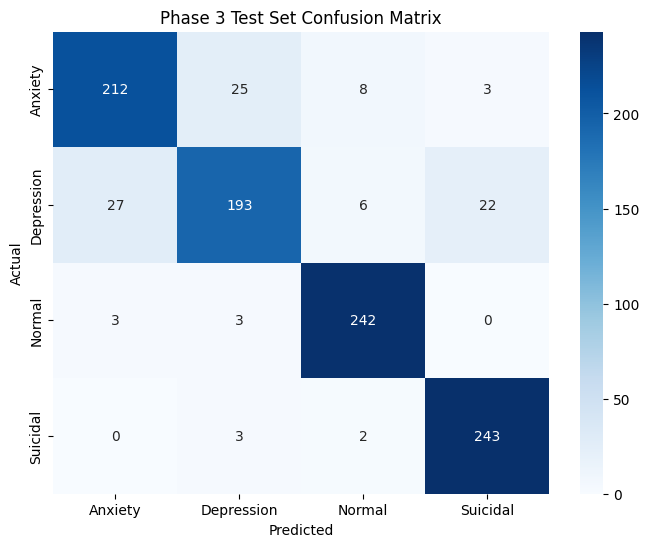

Code Finished in 0.28 seconds


In [12]:
start_time = time.time()
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=list(label2id.keys()), zero_division=0))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label2id.keys(), yticklabels=label2id.keys(), cmap='Blues')
plt.title('Phase 3 Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(f'Code Finished in {time.time() - start_time:.2f} seconds')

## Inference

- The Phase 3 MentalBERT model achieved 90% accuracy and macro F1 on the test set.
- Normal and Suicidal classes were predicted with highest reliability.
- Some overlap in predictions between Anxiety and Depression, but overall results were strong.
- The model is ready for deployment in real-world mental health text classification tasks.
